# Profile Likelihood Fits

designed to accompany the twiki found [here](https://twiki.cern.ch/twiki/bin/viewauth/AtlasProtected/Profilelikelihood) and based on slides given by Lorenzo [here](https://indico.desy.de/indico/event/13610/)

## What is a 'profile likelihood fit'?

A profile (log) likelihood (PLL) fit is a technique to include (or possibly constrain) systematic uncertainties as part of a likelihood fit. To best understand what a PLL fit does it is instructive to compare this to the 'classical' approach to incorporating systematic uncertainties.

### 'Classical approach'
After performing the (log-likelihood) fit for the 'parameter of interest' (POI) (the cross-section, mass or similar quantity of interest):
 - Re-run the fit with the model representing the '+1 $\sigma$' configuration of a systematic uncertainty
 - Re-run the fit with the model representing the '-1 $\sigma$' configuration of a systematic uncertainty
Assign the half the difference of the POI shift between the '+1 $\sigma$' and '-1 $\sigma$' configurations as the uncertainty on the POI due to a given systematic uncertainty (or treat them as an asymmetric uncertainty if warranted). When multiple sources of systematic uncertainty are present, repeat the above procedure for each of those, and add the effects in quadrature.

### 'Profile likelihood approach'

In this approach you modify the model which is fit to the data, so that it can deform its shape according to the effect predicted by a particular systematic uncertainty in a continuous way.

In practice this is usually done taking template histograms based on Geant4 simulation results that describe the predicted shape of the model at nominal, and at-1, +1 $\sigma$ of the systematic uncertainty and then applying an interpolation algorithm that continuously morphs the shape of the distribution from $H(-1\sigma)$ to $H$(nominal) to $H(+1\sigma)$ controlled by an additional 'nuisance parameter' $\alpha$. Conventionally the nuisance parameter is defined such that the model represents $H(-1\sigma)$ at $\alpha=-1$, $H(+1\sigma)$ at $\alpha=1$ and $H$(nominal) at $\alpha=0$.

The most commonly used morphing technique used in ATLAS to interpolate between the histograms is '*vertical morphing*' which adjusts the (vertical) contents of each histogram bin as linear or quadratic function of the $\alpha$ parameter (implemented in [HistFactory](https://twiki.cern.ch/twiki/pub/RooStats/WebHome/HistFactoryLikelihood.pdf). Other options are '[horizontal morphing](https://root.cern.ch/doc/master/classRooIntegralMorph.html)' (or 'integral morphing') which interpolates the cumulative distribution function, which is e.g. used in the [MCLIMIT](https://arxiv.org/abs/hep-ex/9902006) code used at Tevatron.

The modified model $M(x;p,q)$, where $x$ is the observable and $p$ is the parameter of interest (e.g. cross-section), $q$ are the 'other (nuisance) parameters' (floating background shapes, etc) has now gained an additional nuisance parameter $\alpha$ for a systematic uncertainty through the morphing interpolation $M(x;p,q,\alpha)$.

Unlike the classical approach, which effectively corresponds to performing the fit 3 times at fixed values of $\alpha=-1$,$\alpha=0$ and $\alpha=1$, the fit is now performed with $\alpha$ floating. To constrain the variation of $\alpha$ allowed by the fit, the model $M(x,p,q,\alpha)$ is multiplied with a 'constraint term'. [ Note that this nomenclature is somewhat 'Bayesian'; it is used it here for simplicity. In the LL/Frequentist approach such a term is called an 'auxiliary measurement'; it can be constructed to be mathematically equivalent.]

$$ M(x,p,q,\alpha)*\mathrm{Gauss}(\alpha,0,1)$$

A fit of such a model to the data will now automatically propagate the uncertainty from the systematic effect modeled by alpha into the parameter of interest.

## Profile Likelihood Example

In this example we compute an interval using the Profile Likelihood method. 

$$ \lambda ( \mu ) = \frac{ L ( x | \mu, \hat{ \hat { \nu } } ) } { L ( x | \hat{\mu}, \hat{\nu } ) }  $$  

The interval is computed using the asymptotic propriety of $\lambda(\mu)$ based on Wilk's theorem: 

-  $-2 \log { \lambda (\mu ) } $ is distributed as a $\chi^2$ with 1 degree of freedom

In [1]:
using namespace RooStats;

In [2]:
RooStats::LikelihoodInterval * interval = nullptr;
RooStats::LikelihoodIntervalPlot * plot = nullptr; 

##### 1. Reading the model (Workspace) from input file

First part will see us access the workspace file and retrieve the model and the data. For this example any workspace would work. 

Here I use an example workspace built for the CERN analysis preservation efforts and reproducable with the instructions found [here](https://yadage-staging.cern.ch) by running: 

in place of the default `madgraph_delphes` example. The reason for using this workspace in place of any other is that it it built from real MC samples, and processed in a way that mimics a full, large scale analysis as performed by ATLAS or CMS. The code can be found [here](https://github.com/lukasheinrich/fullpreservation_example_one), but any workspace should work. Alternatively the file containing this workspace can be downloaded directly from this directory.

In [3]:
TString fileName = "../workspaces/workspace_combined_meas_model.root";
TString workspaceName = "combined";
TString modelConfigName = "ModelConfig";
TString dataName = "asimovData";
TString integrationType = "";  

In [4]:
auto file = TFile::Open(fileName);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [ ]:
auto w =  (RooWorkspace*) file->Get(workspaceName);
w->Print();
auto mc = (RooStats::ModelConfig*) w->obj(modelConfigName);
auto  data = w->data(dataName);
auto poi = (RooRealVar*) mc->GetParametersOfInterest()->first();  // get POI 

#### 2. Create and configure `ProfileLikelihoodCalculator` class

In [6]:
RooStats::ProfileLikelihoodCalculator plCalc(*data,*mc);

Set the Confidence Level for the interval (e.g 0.95 for a 95% interval)

In [7]:
plCalc.SetConfidenceLevel(0.90);

#### 3. Compute the interval

Run the calculator by performing the unconditional and conditional fits (profiling the nuisance parameters)

In [8]:
interval = plCalc.GetInterval();

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization --  Including the following contraint terms in minimization: (lumiConstraint,alpha_mc1_weight_var1Constraint,alpha_mc1_shape_convConstraint,alpha_mc2_weight_var1Constraint,alpha_mc2_shape_convConstraint)
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_simPdf_asimovData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
RooAbsTestStatistic::initSimMode: creating slave calculator #0 for state channel1 (50 dataset entries)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(channel1_model_Int[obs_x_channel1]) using numeric integrator RooBinIntegrator to calculate Int(obs

In [9]:
lowerLimit = interval->LowerLimit(*poi);
upperLimit = interval->UpperLimit(*poi);

In [10]:
cout << 100*plCalc.ConfidenceLevel() << "% interval is : ["<< lowerLimit << ", "<< upperLimit <<"] "<<endl;

90% interval is : [0.528769, 1.4693] 


#### 4. Visualize the Interval

In [11]:
plot = new RooStats::LikelihoodIntervalPlot(interval);
//plot->SetNPoints(50);   // if plotting takes a long time
plot->SetRange(0,3);

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_asimovData_with_constr_Profile[SigXsecOverSM]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_simPdf_asimovData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_asimovData_with_constr_Profile[SigXsecOverSM]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_asimovData_with_constr_Profile[SigXsecOverSM]) minimum found at (SigXsecOverSM=0.999863)
......................................................................................................

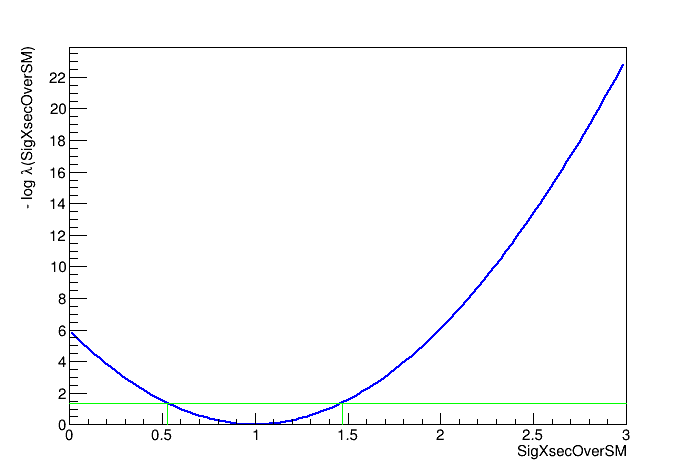

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [12]:
plot->Draw("TF1"); gPad->Draw();

## Equivalence of PLL and Classical results - Effect of in-situ constraining

If the Likelihood $L(p,q,\alpha)$ constructed from model $M(x,p,q,\alpha)$ and dataset $D(x)$ exhibits little sensitivity to $\alpha$ the systematic uncertainties obtained in the classical and PLL approach will be very similar.

Differences can arise in the case of multiple sources of systematic uncertainties, or in cases where the dataset $D(x)$ is quite sensitive to deformations due to systematic uncertainties and may effectively 'in-situ constrain' the systematic uncertainties from the data.

Starting with the latter - we can take as an example a '*jet energy scale*' systematic uncertainty. If e.g. a counting experiment is performed to a simple event selection (e.g. $N_\mathrm{jet}(p_\mathrm{T}>25)>=4)$ we expect the corresponding cross-section to be affected by this systematic through the acceptance, but there are no features in the data that would allow to disentangle the effect of a modified signal cross-section and a change in JES. If a likelihood fit is performed to such a model (using a Poisson model for the event count) the profile likelihood fit will propagate the nominal (input) uncertainty on JES to the cross-section, but nothing more. In the output fit result, this is reflected by having a nuisance parameter $\alpha_\mathrm{JES}$ that has an estimated uncertainty of 1 and a value consistent with zero, where the uncertainty of 1 is realized by the Gauss($\alpha_\mathrm{JES}$,0,1) term of the profile likelihood model. This reduces the sensitivity of the measurement or search by effectively broadening the PLL function.

Now we can take another case were we make an 'enhanced' measurement which models the event rate in three jet bins ($N_\mathrm{jet}==3$, $N_\mathrm{jet}$==4, $N_\mathrm{jet}$>=5). In this case we expect that the effect of a change in signal cross-section on the three event yields is different from the effect of a change in jet-energy scale, thus a fit to the data can also indicate what range of value of $\alpha_\mathrm{JES}$ are (statistically) consistent with the data, even when the signal cross-section is not assumed to be known. If statistics are poor, this may be a very wide range, in which case the range of $\alpha_\mathrm{JES}$ is effectively controlled by the term Gauss($\alpha_\mathrm{JES}$,0,1), but with sufficiently high statistics the PLL fit may indicate that only a smaller range of $\alpha_\mathrm{JES}$ is consistent with the data. If this is the case, the PLL fit result will show a fitted $\alpha_\mathrm{JES}$ parameter with a fit uncertainty smaller than unity and this (smaller) uncertainty will be propagated as the effect of this systematic uncertainty into the parameter-of-interest. Effectively the fit operates like an 'in situ calibration' for this source of uncertainty.

This reduction of uncertainties is the key feature of PLL fits and is its essential strength as it turns a systematic uncertainty into a statistical uncertainty (that will thus always be further reducible with additional data). From a statistical/mathematical point of view this is a completely valid approach, but from a physics point of view its validity also depends on the validity of any modeling assumptions that were made to parameterize this systematic uncertainty. *This is a central question in the review of PLL analyses that significantly constrain leading uncertainties in-situ with respect to the input uncertainty.* For 'singular' systematics, with a single well-defined underlying parameter (e.g. 'more pileup', 'less pileup'), this modeling is usually not a problem, but it can be for 'compound' or 'discrete' systematic uncertainties. Compound systematic uncertainties are uncertainties that have multiple known contributions or sources (each with a distinct effect on the distribution being fitted) that are lumped together by convention (such as JES - which has currently up to 9 defined individual contributions). If the individual components result in very different distortions of the model, it may not be safe to model such systematics with a simplified 'rigid' model. Systematic uncertainties that are fundamentally of a discrete nature may not be eligigble as well for profiling. Details on the treatment of either type of systematic are discussed below.

## Examining the output of PLL fits

As profile likelihood fits are potentially capable of constraining the effect of systematic uncertainties from the data, the fitted parameter values and their correlations are excellent diagnostic tools.

**RECOMMENDATION I**: The internal documentation of any profile likelihood analysis should always show the full list of fitted parameters and their uncertainties, as well as the correlation matrix.

In the list of profile parameters one can distinguish:
 1. Parameters with a fitted uncertainty of $~1$
 2. Parameters with a fitted uncertainty of $>1$
 3. Parameters with a fitted uncertainty of $<1$

The parameters of class 1 represent profile parameters for which the fit to data does not yield any sensitivity to the systematic uncertainty and the uncertainty is constrained by its prior term (where a fit error of 1 means that the input uncertainty is assumed). The central value of such profile parameters should be consistent with zero (within the error - taking into account this is nominally a 68% CL error - so if there are many profile parameters, it is natural to expect some $>1 \sigma$ deviations).

The parameters of class 2 should not exist and if found represent underlying problems. The most common type of problems are an incorrect input error normalization, fits that did not converge, or pathologies in the likelihood. In all cases these should be investigated by the authors and fixed.

The parameters of class 3 represent profile parameters for which the fit to data has sufficient sensitivity to the systematic uncertainty that it can constrain the allowed variations of the corresponding nuisance parameters beyond the a priori uncertainty. For all such parameters one should understand (at a basic level) if the fitted distributions contain information that is sensitive to these systematic uncertainties, *e.g. if one fits jet multiplicity distributions one naturally expects to be sensitive to JES and ISR effects*. If profiling results in a substantially reduced uncertainty, one should also think a bit more about the parameterization of the systematic uncertainty: This is addressed in the two sections below. Also note that (especially) for strongly constrained parameters is it possible to obtain values that are inconsistent with zero within the fitted uncertainties, e.g $0.4 \pm 0.1$. This is not necessarily a problem, as such a measurement is still consistent with the a priori expectation of $0 \pm 1$.

One should take care not to overstate the applicability of PLL results to estimate systematic uncertainties: A result of $0.4 \pm 0.1$ for e.g. a JES nuisance parameter does not mean that the JES is off by some significant amount in general, it just works out that the effect of JES for this particular analysis (which may have strong biases due to selection criteria that emphasise particular regions of jet phase space, or involve observables that enhance or reduce the effects of JES in particular ways) needs to be shifted an amount that is still smaller than the a priori uncertainty to obtain the best fit. Neither can an unexpectedly small uncertainty on a JES nuisance parameter in a PLL fit be taken at face value to mean that the 'global' JES uncertainty should be reduced to the given amount, even if only a global scale factor was fitted. You simply don't know if the fraction of jet phase space that was sampled in a given analysis is representative for jets in general, or there are cancellation or enhancement effects in the observations that alter the effect of JES.

## Breakdown of systematic uncertainties

A profile likelihood fit defines only the total error in an unambiguous way, so some care must be taken in making the breakdown of systematic uncertainties and interpreting what these tables mean. The main source of non-triviality in the behaviour of PLL fits is that the likelihood can introduce correlations between parameters. Generally the likelihood is defined as
$$
L(p,q,\alpha) = \sum_\mathrm{data} -\log \mathrm{model}(x_i ; p,q,\alpha)  - \sum_i \log \mathrm{Gauss}(\alpha_i,0,1)
$$
where the first part is the 'plain' likelihood defined by the data and the pdf model, and the second part is the sum of the Gaussian 'a priori' constraints on the nuisance parameters. The second part is clearly factorizing in the various $\alpha_i$ such that the source of correlations comes from the first part - the 'plain' likelihood. Rephrasing this point in a different form, in a PLL fit the *source* uncertainties (such as JES, ISR) are assumed to be 100% uncorrelated a priori, but the shape of the data and their effect on the model may introduce observed correlations at the likelihood level. There is nothing magic about this: If you construct a 'plain' model like a Gaussian plus a Polynomial you will also find that some parameters happen to have a correlation in the likelihood - this follows from the mathematics of the formulation. The existence of such correlations however spoils the simple 'summing in quadrature' behaviour of systematic uncertainties.

The most common approach to defining the 'per-component' systematic uncertainty for PLL works as follows:
1. Run the fit with all nuisance parameters floating --> uncertainty = total uncertainty (syst + stat)
2. Run the fit with all nuisance parameters floating except those in the category of interest' --> uncertainty = stat + all.other.syst The 'component of interest' nuisance parameters are kept fixed at the values found by the 'all parameters floating' fit.
3. The reported uncertainty due to the systematic uncertainty component is the difference in quadrature err_syst.comp = $\sqrt{\mathrm{error}_1^2 - \mathrm{error}_2^2}$.

This procedure is then repeated for each component of the systematic uncertainty. Note that for the breakdown systematic uncertainties can be grouped arbitrarily, e.g. to report a (total) JES systematic, step 2) can be performed by taking all JES component nuisance parameters to be fixed simultaneously.

Similarly the 'stat-only' uncertainty is found by fixing all nuisance parameters, and the 'all-syst' uncertainty is the difference in quadrature between the 'total uncertainty' and the 'stat-only' uncertainty.

Features of tables of systematic uncertainties made this way are:
 * Component systematic uncertainties don't add up in quadrature to the total systematic uncertainty. This happens due to correlations between the systematic uncertainty categories.
 * Numerical precision of estimates of systematic uncertainty components that result in small errors may be poor. This happens as the reported values are the differences of two large numbers subtracted in quadrature - which amplifies numerical noise and fit stability issues.
 * Uncertainties can be strongly asymmetrical if the fit involves low statistics and/or the reported component represents a comparatively small uncertainty, as both lead to increased sensitivity due to numerical precision. In such cases the 'upper' and 'lower' uncertainties are subtracted quadratically separately. If there are numerical precision issues in both, the odds of ending up with highly asymmetric results are large as numerical uncertainties move the upper and lower uncertainty independently.
 * Be aware that fit option 2 may find a different minimum for its floating parameters than fit option 1. There is nothing you can do about this. You can still subtract these errors in quadrature, but in some sense you are subtracting apples from pears...
 
It is important to keep in mind that there is always some conceptual approximation made when reducing the output of a PLL fit to a 'simple' table of systematic uncertainties due to the correlations between systematic uncertainties at the LL level.

**RECOMMENDATION V**: If any of these problems arise at a level where it is problematic, a suitable alternative can be to present the expected breakdown of systematic uncertainties rather than the observed one. The former is constructed by performing the aforementioned exercise for a larger number of toy MC datasets and reporting the average fraction - thereby averaging out fluctuations due to (low) statistics.